# Panorama - Image Stitching

We're going to use feature detection and perspective transformation to stitch two images together to create panorama image. Used photo by [Madhu Shesharam](https://unsplash.com/@madhu_shesharam).

### Preparation 

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_images(*imgs, figsize=(30,20), hide_ticks=False):
    '''Display one or multiple images.'''
    f = plt.figure(figsize=figsize)
    width = np.ceil(np.sqrt(len(imgs)))
    height = np.ceil(len(imgs) / width)
    for i, img in enumerate(imgs, 1):
        ax = f.add_subplot(height, width, i)
        if hide_ticks:
            ax.axis('off')
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

Load images.

In [3]:
left = cv2.imread('src_left.jpg')
right = cv2.imread('src_right.jpg')

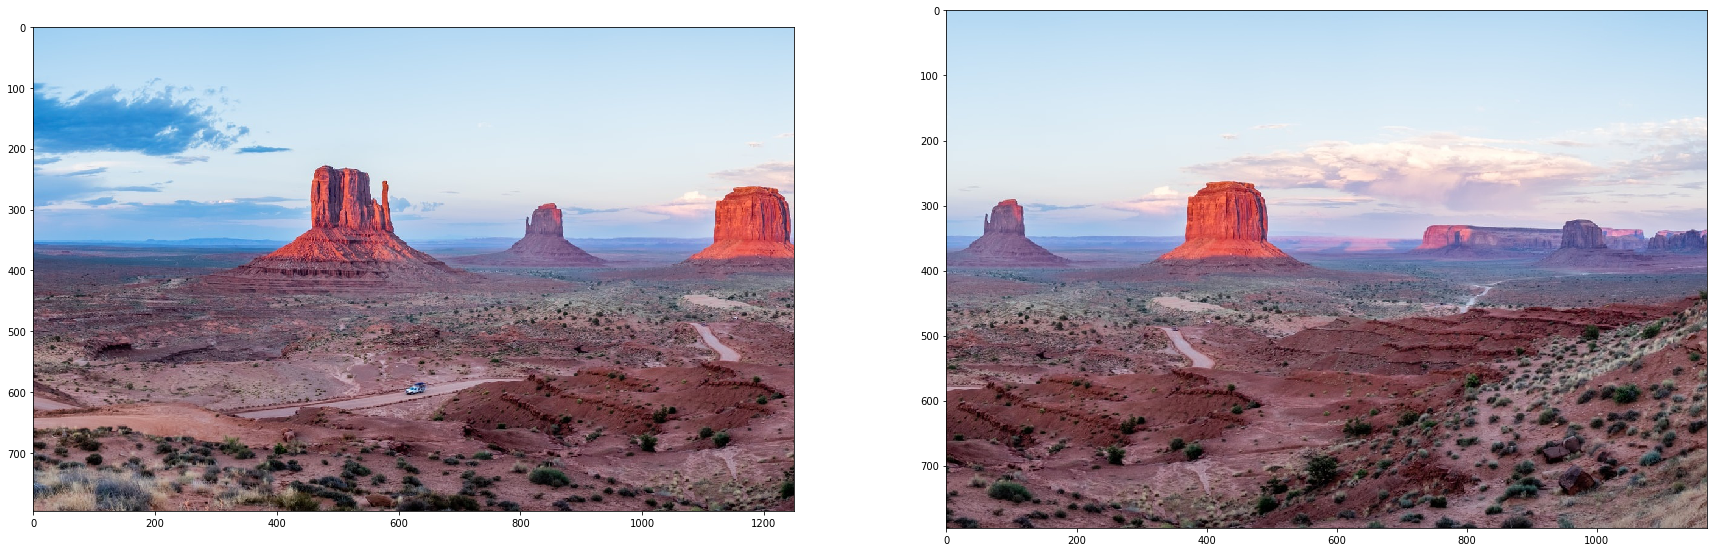

In [4]:
plot_images(left, right)

### Feature detecton and matching

We're going to use **[ORB](https://en.wikipedia.org/wiki/Oriented_FAST_and_rotated_BRIEF)** to extract key features from images. For more details see for example [this OpenCV tutorial](https://docs.opencv.org/3.4/d1/d89/tutorial_py_orb.html).

In [5]:
orb = cv2.ORB_create()

`detectAndCompute` returns two arrays:

- **keypoint** represents some important point in source image (location and importance). 
- **descriptor** in some way (depends on algorithm) describes given *keypoint*. This description provides to image changes like translation and rotation and allow us to match same/similar keypoints on different images.

In [6]:
kp_left, des_left = orb.detectAndCompute(left, None)
kp_right, des_right = orb.detectAndCompute(right, None)

We can easily visualize found *keypoints* with OpenCV.

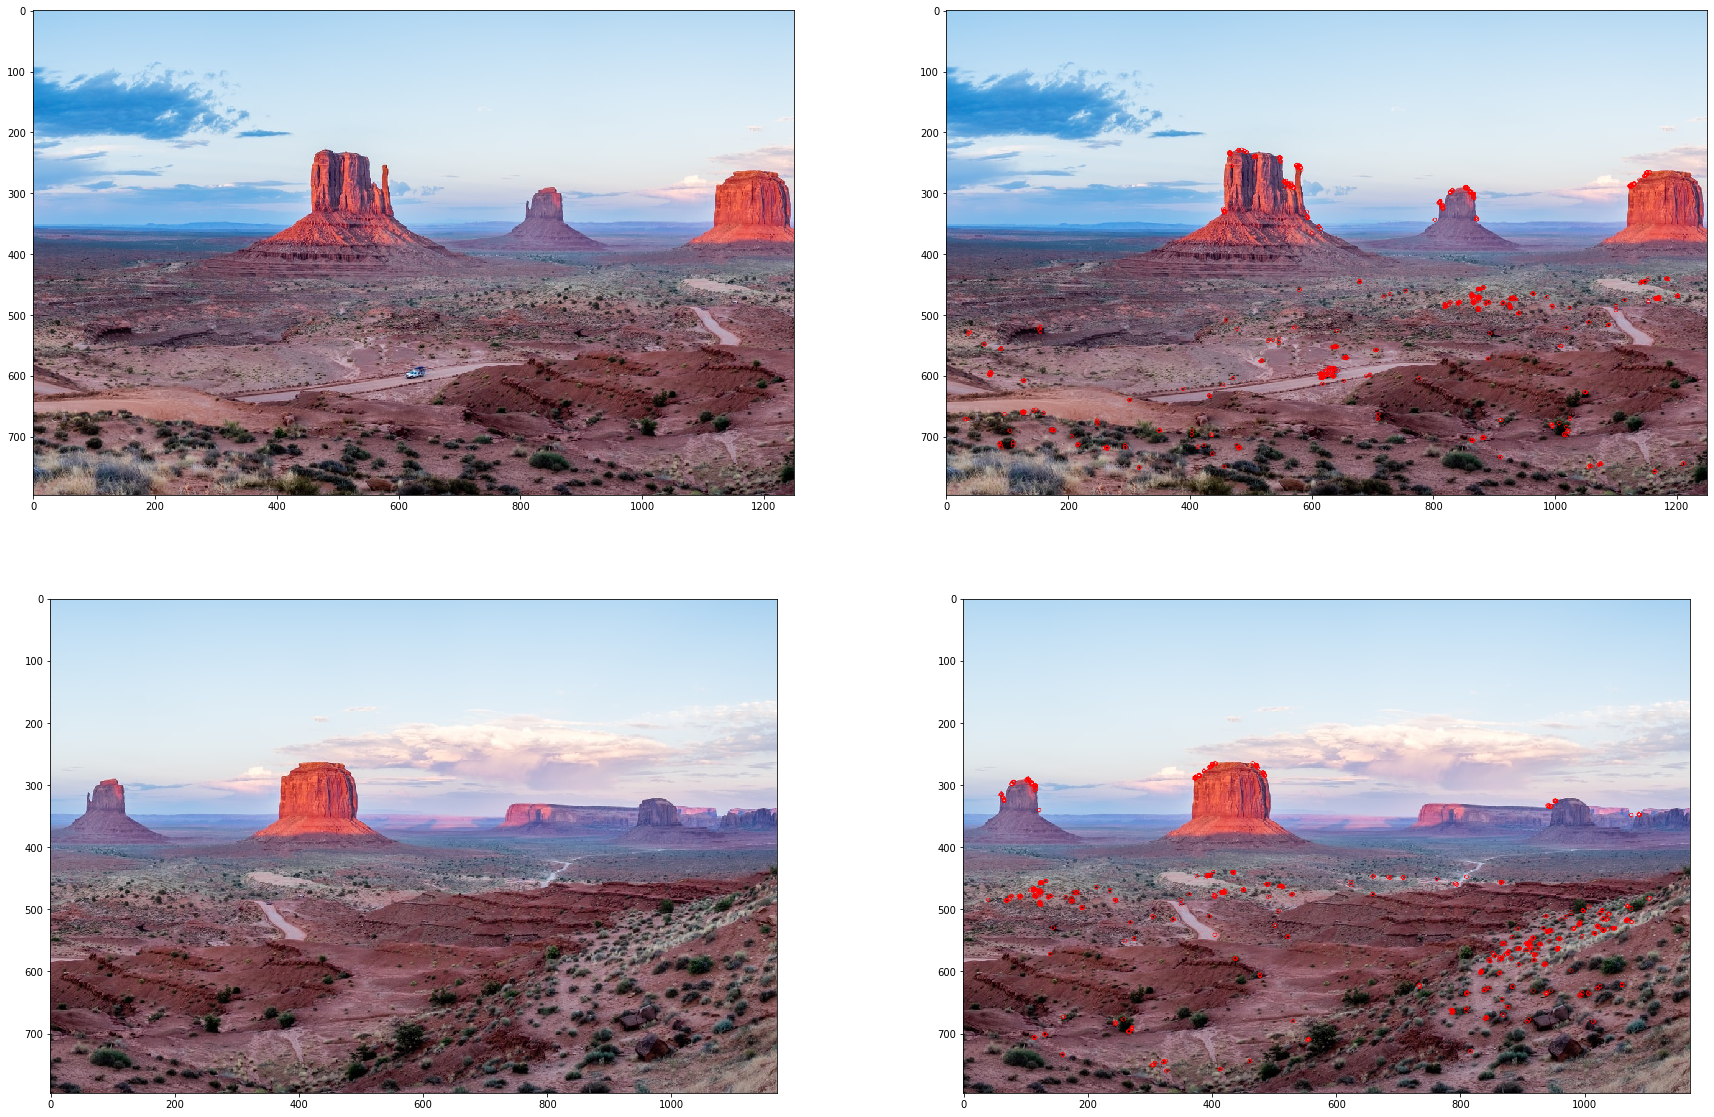

In [7]:
keypoints_drawn_left = cv2.drawKeypoints(left, kp_left, None, color=(0, 0, 255))
keypoints_drawn_right = cv2.drawKeypoints(right, kp_right, None, color=(0, 0, 255))

plot_images(left, keypoints_drawn_left, right, keypoints_drawn_right)

Now we need to find which descriptors match each other. We will use OpenCV brute-force matcher. We will use Hamming distance instead of the default L2 norm because it's better match for ORB. For more details see [e.g. this](https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html).

In [8]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des_left,des_right)

We can visualise the matches, but there's a lot going on. We will solve this below.

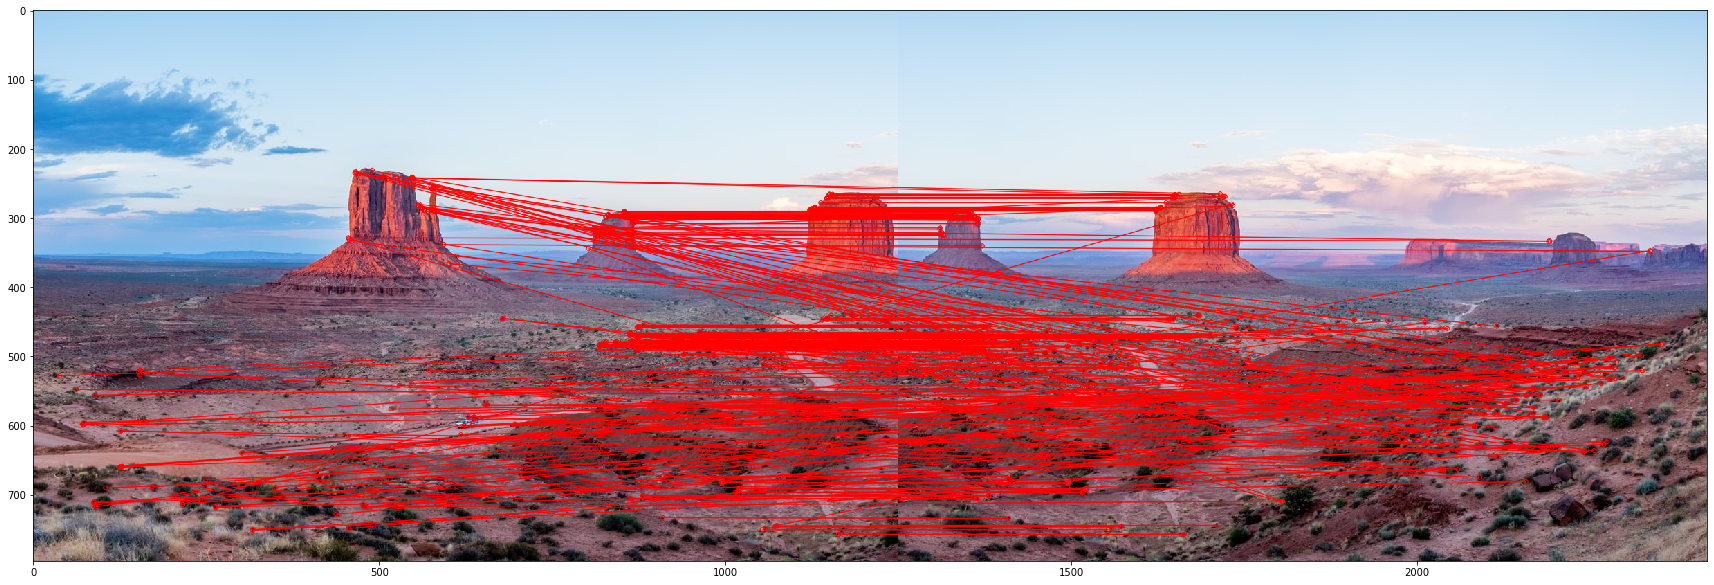

In [9]:
matches_drawn = cv2.drawMatches(left, kp_left, right, kp_right, matches, None, matchColor=(0,0,255), flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
plot_images(matches_drawn)

We will select only a few of the best matches and visualise again.

In [10]:
limit = 10
best = sorted(matches, key = lambda x:x.distance)[:limit]

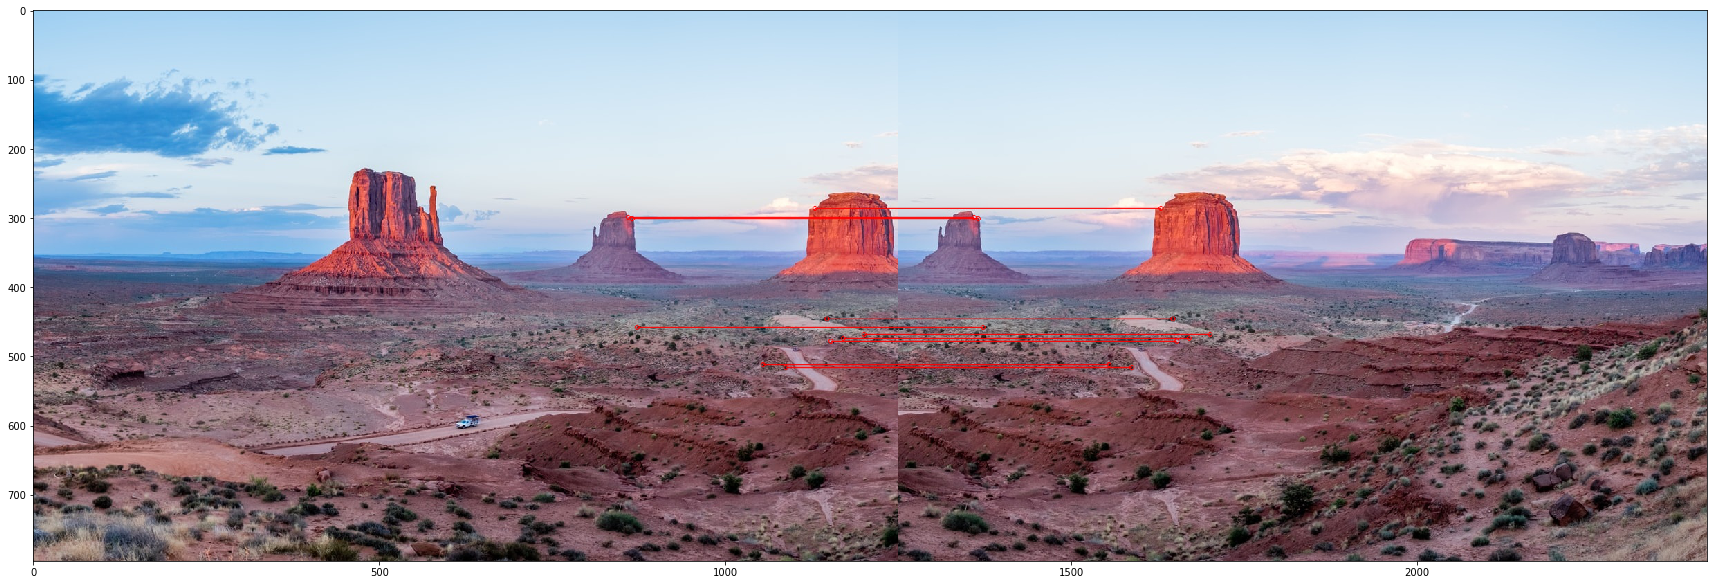

In [11]:
best_matches_drawn = cv2.drawMatches(left, kp_left, right, kp_right, best, None, matchColor=(0,0,255), flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
plot_images(best_matches_drawn)

### Perspective transformation and finalization

We will convert the best matches to coordinates on the left and right picture...

In [12]:
left_pts = []
right_pts = []
for m in best:
    l = kp_left[m.queryIdx].pt
    r = kp_right[m.trainIdx].pt
    left_pts.append(l)
    right_pts.append(r)

... and compute the transformation.

In [13]:
M, _ = cv2.findHomography(np.float32(right_pts), np.float32(left_pts))

In [14]:
dim_x = left.shape[1] + right.shape[1]
dim_y = max(left.shape[0], right.shape[0])
dim = (dim_x, dim_y)

warped = cv2.warpPerspective(right, M, dim)

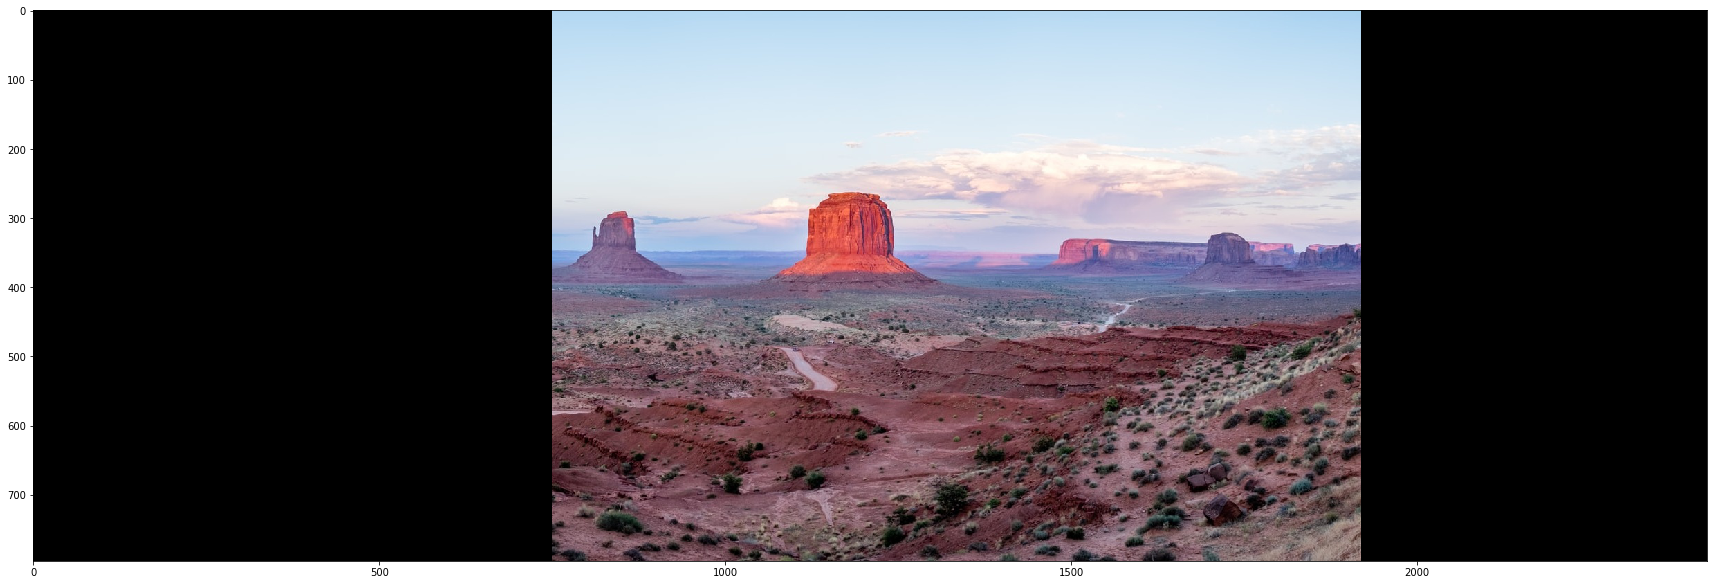

In [15]:
plot_images(warped)

Finally we cat put the two images together.

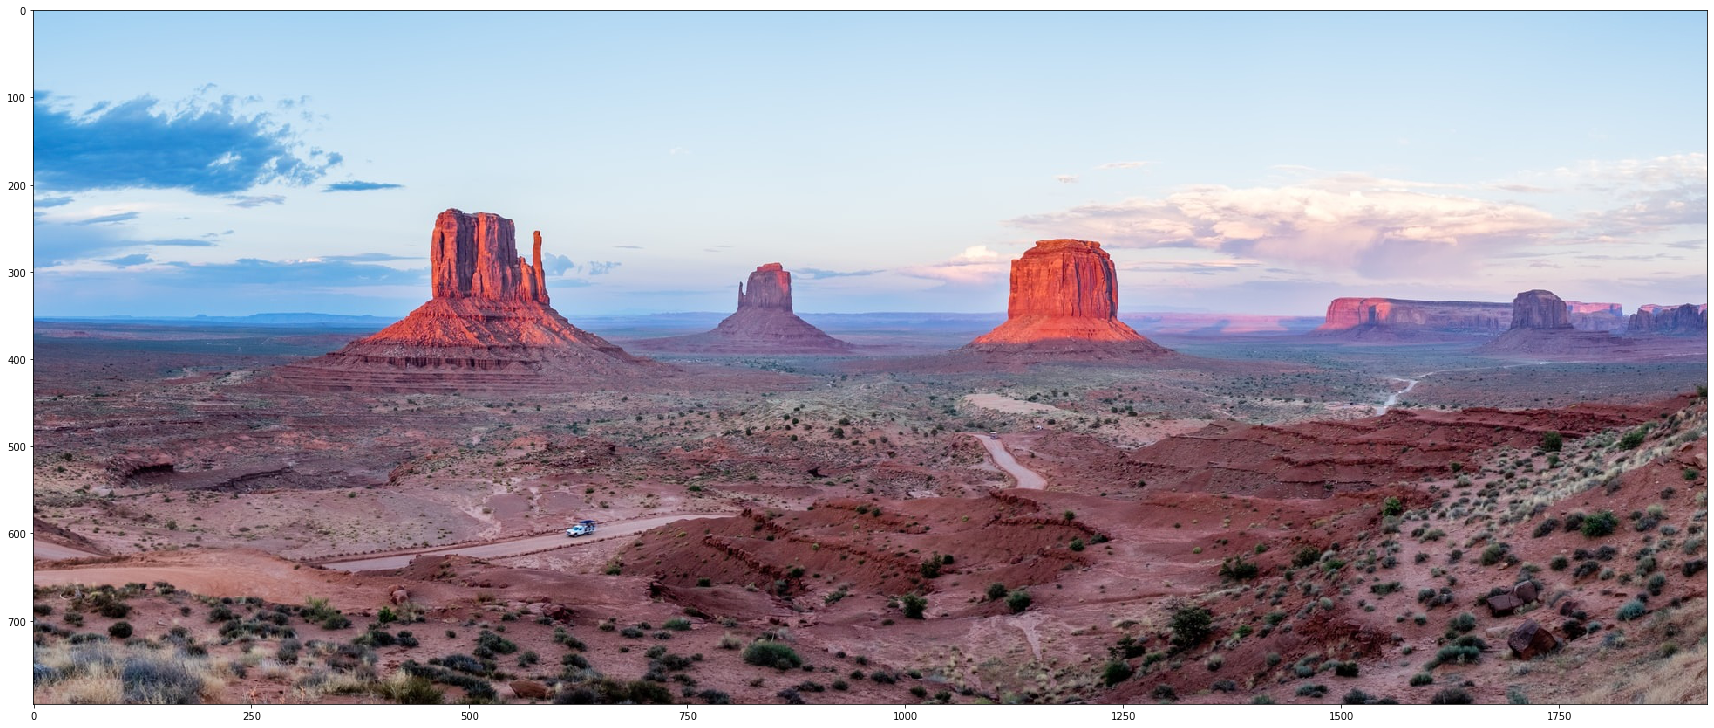

In [16]:
comb = warped.copy()
# combine the two images
comb[0:left.shape[0],0:left.shape[1]] = left
# crop
r_crop = 1920
comb = comb[:, :r_crop]
plot_images(comb)

#### Sources

- https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html
- https://www.pyimagesearch.com/2018/12/17/image-stitching-with-opencv-and-python/
- https://dsp.stackexchange.com/a/10424
- https://medium.com/analytics-vidhya/image-stitching-with-opencv-and-python-1ebd9e0a6d78
- https://www.pyimagesearch.com/2018/12/17/image-stitching-with-opencv-and-python/
- https://unsplash.com/photos/TZHwKBU8rig